# Introduction to Sparsity II: Compressed Sensing

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
 * [Objective](#Objective)
 * [Nyquist-Shannon Sampling Theorem](#Nyquist-Shannon-Sampling-Theorem)
 * [Compressed Sensing](#Compressed-Sensing)
1. [1D Example](#1D-Example)
 * [Sparse Signal](#Sparse-Signal)
 * [Fourier Transform](#Fourier-Transform)
 * [Observation](#Observation)
 * [Inverse Problem](#Inverse-Problem)
 * [Optimisation Algorithm](#Optimisation-Algorithm)
 * [Gradient](#Gradient)
 * [Solution](#Solution)
 * [Performance](#Performance)
1. [2D Exercise](#2D-Exercise)
 * [Problem](#Problem)
 * [Data](#Data)
 * [Solutions](#Solutions)
1. [Bonus Question](#Bonus-Question)

---

## Set-Up

Here we will import a couple of packages that we be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np

# Import function to set size of figures.
from matplotlib.pylab import rcParams

# Import interaction module.
from ipywidgets.widgets import *

# Import tutorial functions.
from sparsity_tutorial import plot
from sparsity_tutorial.functions import l1_norm, sigma_mad

In [2]:
# For Python 2 users only
# Uncomment the following commands

# Import Python 3 behaviour
# from __future__ import print_function

In [3]:
# Set size of figures.
rcParams['figure.figsize'] = (14.0, 8.0)

---

## Introduction

### <font color='blue'>Objective</font>

This notebook aims to give a brief introduction to how CS works in practice without getting into too much mathematical detail. For more comprehensive details please see *e.g.*

* <a href="https://ieeexplore.ieee.org/document/1580791/" target_="blank">Candès et al (2006b)</a>
* <a href="https://ieeexplore.ieee.org/document/4016283/" target_="blank">Candès and Tao (2006)</a>
* <a href="https://ieeexplore.ieee.org/document/1614066/" target_="blank">Donoho (2006a)</a>

### <font color='blue'>Nyquist-Shannon Sampling Theorem</font>

The Nyquist-Shannon Sampling Theorem dictates that a bandlimited singal can perfectly be recovered if the sample frequency, $f_s$, (*i.e.* number of sample taken per unit time/space) is at least twice the highest frequency contained in the signal, $f_c$.

$$f_s \geq 2f_c$$

In the following cell you can see a sine wave (green dotted line) that we wish to recover. Initially this signal is sampled well below the Nyquist rate (blue dots). The resulting effect, known as aliasing, creates the illusion of a signal with a lower frequency (red line). Try increasing the sampling rate and/or frequency to see what happens.

In [4]:
# function to plot signal of given frequency with a given sampling rate
def sampling(sampling_rate, frequency):

    t = np.arange(0, 1, 1.0 / sampling_rate)
    y = np.sin(2 * np.pi * frequency * t)
    plot.stem_plot(y, x_vals=t, title='Aliasing', imag=False, ylim=(-1.1, 1.1), line=True, f=frequency)
    
sampling_slider = IntSlider(value=9, min=2, max=42, step=1)
frequency_slider = IntSlider(value=10, min=1, max=10, step=1)
    
interact(sampling, sampling_rate=sampling_slider, frequency=frequency_slider)

interactive(children=(IntSlider(value=9, description='sampling_rate', max=42, min=2), IntSlider(value=10, description='frequency', max=10, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.sampling>

### <font color='blue'>Compressed Sensing</font>

Compressed (or compressive) sensing (CS) is a paradigm that allows one to sample certain singals at a rate lower than the Nyquist rate by exploiting the sparsity of the signal in a given domain.

---

## 1D Example

To get a more intuitive understanding of how the principles of CS work we begin with an example of a very simple 1D signal. This example will demonstrate how to recover the signal from a masked observation.

### <font color='blue'>Sparse Signal</font>

First we define a sparse signal, $\alpha$, with 128 coefficients of which only 5 have non-zero values (*i.e.* a $k$-sparse singal with $k=5$).

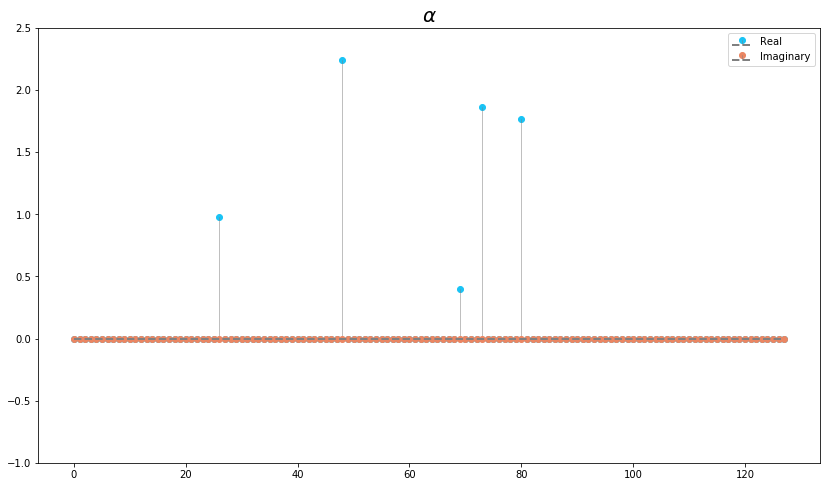

In [5]:
# full sample size
n_samples = 128

# number of peaks
n_peaks = 5

# random seed used to ensure reproducibility of results
np.random.seed(0)

# generate the singal alpha
alpha = np.random.permutation(np.hstack((np.random.randn(n_peaks), np.zeros(n_samples - n_peaks))))

# plot real and imaginary components of alpha
plot.stem_plot(alpha, title=r'$\alpha$')

### <font color='blue'>Fourier Transform</font>

Next we want to generate a new signal $x$ which is the Fourier transform of $\alpha$. *i.e.*

$$x = \phi\alpha$$

where $\phi$ is a normalised FFT

$$\phi z = \frac{1}{\sqrt{n}} \mathcal{F}(z)$$

and $n$ is the size of the signal. The corresponding inverse operation is

$$\phi^{-1} z = \sqrt{n} \mathcal{F}^{-1}(z)$$

In the following cell we define functions to compute $\phi$ and $\phi^{-1}$.

In [6]:
# normalised FFT
def fft(data):
    
    return 1 / np.sqrt(data.size) * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(data)))
#     return np.fft.fft(data)

# normalised inverse FFT
def ifft(data):

    return np.sqrt(data.size) * np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(data)))
#     return np.fft.ifft(data)

<font color='orange'>INTERACTION:</font> Use the functions above to generate the singal $x$.

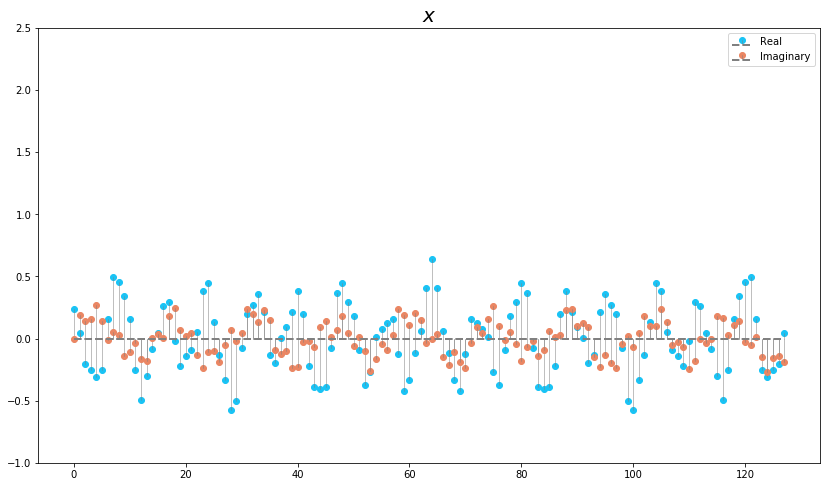

In [7]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# generate signal x
x = fft(alpha)
# x = None

# plot real and imaginary components of x
if x is not None:
    plot.stem_plot(x, title=r'$x$')

### <font color='blue'>Observation</font>

To simulate a CS problem we need to randomly subsample $x$ in order to generate an observation (or acquisition) $y$. We can do this using a masking operator $H$ that we define in the cell below.

In [8]:
# Function to mask a signal.
def mask_op(signal, mask):

    return signal[np.where(mask == 1)[0]]

For this example we will keep only a quarter of the coefficients in $x$.

<font color='orange'>INTERACTION:</font> Define a mask that can be used with above function that will keep only $25\%$ of the coefficients.

In [9]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# set the number of non-zero coefficients retained
n_subsamples = n_samples // 4
# n_subsamples = None

# generate the mask
mask = np.random.permutation(np.hstack((np.ones(n_subsamples), np.zeros(n_samples - n_subsamples))))

Now, we can model $y$ as 

$$y = H\phi\alpha$$

<font color='orange'>INTERACTION:</font> Use the mask you defined to generate the observation $y$.

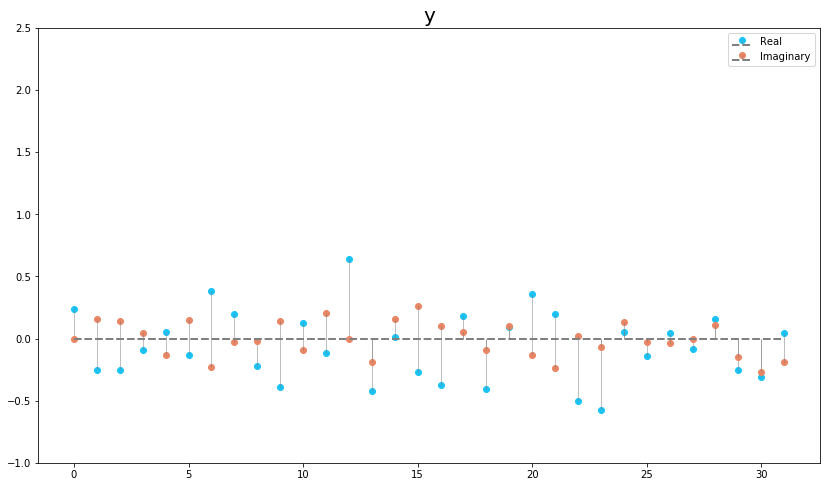

In [10]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# generate the subsampled observation y
y = mask_op(x, mask)
# y = None

# plot real and imaginary components of y
if y is not None:
    plot.stem_plot(y, title='y')

Notice that the signal $y$ is indeed shorter than $x$, however in order to properly visualse this masked signal we need to upsample.

Upsampling will simply place zeros at the positions of the coefficients masked in $x$. This operation also constitutes the inverse operation of $H$, which we denote $H^T$ as is defined in the cell below.

In [11]:
# Function to upsample a signal.
def upsample(signal, mask, dtype=complex):

    val = np.copy(mask).astype(dtype)
    val[val == 1] *= signal
    return val

Now we can display the upsampled version of $y$.

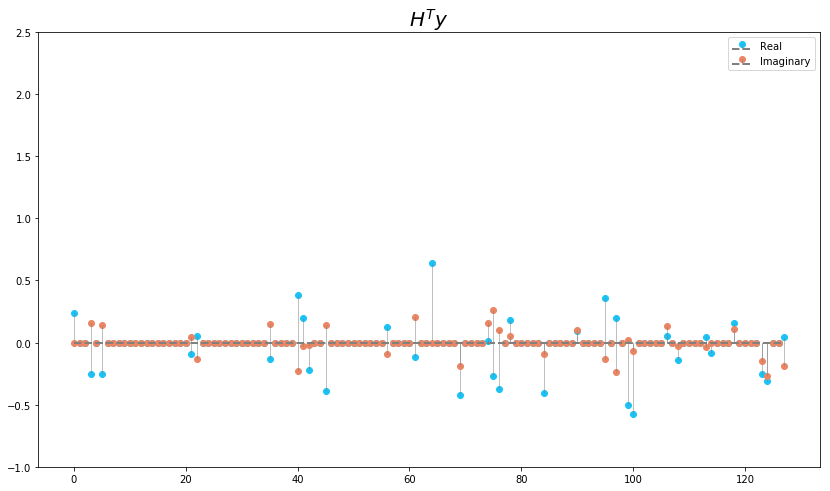

In [12]:
# plot real and imaginary components of y
if y is not None:
    plot.stem_plot(upsample(y, mask), title=r'$H^Ty$')

### <font color='blue'>Inverse Problem</font>


The problem we aim to solve is to recover the original signal $\alpha$ from $y$ given that we know both $\phi$ and $H$. This corresponds to the following optimisation problem

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|y-H\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we implement sparse regularisation given that we know a priori that $\alpha$ is sparse. We can implement $l_1$ regularisation via soft thresholding of the sparse coefficients. For this example we also have to manage the complex coefficients of the signal, which we do using the following function.

In [13]:
# Function for performing soft thresholding with complex coefficients.
def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold / np.maximum(np.finfo(np.float64).eps, np.abs(data))),0.0) * data, 
                     decimals=15)

For a given estimate of $\alpha$ the optimisation problem provides the cost of the solution. To solve this problem we aim to minimise this cost, which we will cacluate with the following function.

In [14]:
# Function to calculate the cost.
def cost_func(y, alpha_rec, mask, lambda_val):
    
    return (0.5 * np.linalg.norm(y - mask_op(fft(alpha_rec), mask)) ** 2 + lambda_val * l1_norm(alpha_rec))

### <font color='blue'>Optimisation Algorithm</font>
    
For this exercise we will use the forward-backward splitting algorithm with a soft thresholding operation to promote sparse solutions. It has the following form for each iteration

$$\alpha_{n+1} = \alpha_n - \gamma * \nabla F(\alpha_n)$$
$$\alpha_{n+1} = \text{ST}_\lambda(\alpha_{n+1})$$

Where $\nabla F(\alpha_n)$ corresponds to the gradient of our optimisation problem. The function we will use to implement the algorithm is provided below.

In [15]:
# Function that performs simple forward backward splitting.
def forwardBackward(observation, first_guess, mask, grad, lambda_val, n_iter=300, gamma=1.0, return_cost=False):
    
    alpha_rec = first_guess
    cost = []
            
    for i in range(n_iter):
        
        alpha_temp = alpha_rec - gamma * grad(observation, alpha_rec, mask)
        alpha_rec = soft_thresh(alpha_temp, lambda_val)
        cost.append(cost_func(observation, alpha_rec, mask, lambda_val))
    
    if return_cost:
        return alpha_rec, cost
    else:
        return alpha_rec

### <font color='blue'>Gradient</font>

The gradient of the above problem is given by

$$\nabla F(\alpha) = \phi^{-1}H^T(H\phi\alpha-y)$$

<font color='orange'>INTERACTION:</font> write a funciton that implements the gradient calculation.

In [16]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Function to calculate the gradient
def grad(y, alpha_rec, mask):

    return ifft(upsample(mask_op(fft(alpha_rec), mask) - y, mask))

### <font color='blue'>Solution</font>

Now we can use the forward-backward algorithm to recover $\alpha$. Notice how the solution improves after a given number of iterations until converges on a very good reconstruction of $\alpha$.

In [17]:
# Interactive function to plot the recovered alpha after a given number of iterations
def solve(n_iter):
    
    alpha_rec, cost = forwardBackward(observation=y, first_guess=np.ones(n_samples), mask=mask, grad=grad,
                                      lambda_val=0.01, n_iter=n_iter, gamma=1.0, return_cost=True)
    
    plot.stem_plot(alpha_rec, title=r'$\hat{\alpha}$')
    plot.cost_plot(cost)
        
slider = IntSlider(value=1, min=1, max=361, step=40)
interact(solve, n_iter=slider)

interactive(children=(IntSlider(value=1, description='n_iter', max=361, min=1, step=40), Output()), _dom_classes=('widget-interact',))

<function __main__.solve>

Notice that the solution converges after roughly 200 iterations.

### <font color='blue'>Performance</font>

Finally, we can test the quality of our solution by comparing our recovered $\hat{\alpha}$ with the true $\alpha$. Notice that the difference between the two signals is extrmeley small even for the imaginary components.

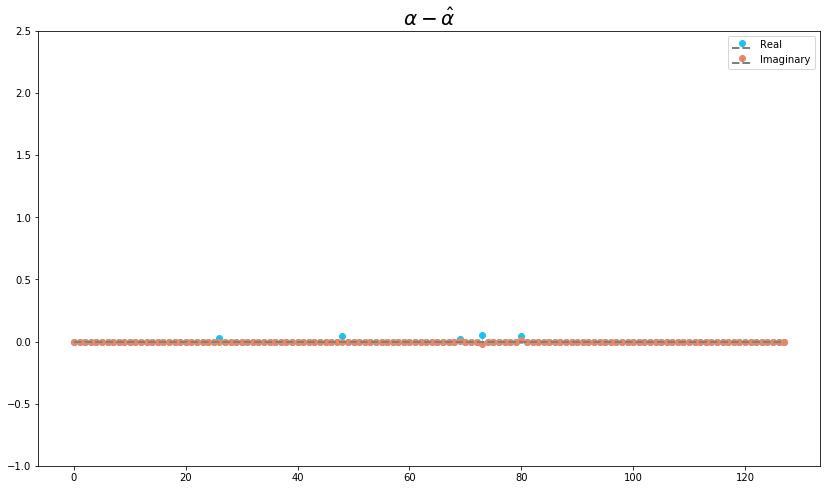

In [18]:
# recoved signal after 200 iterations
alpha_rec = forwardBackward(y, np.ones(n_samples), mask, grad, 0.01, 200, 1.0)

# plot real and imaginary components of true alpha - recoved alpha
plot.stem_plot(alpha - alpha_rec, title=r'$\alpha - \hat{\alpha}$')

The Normalised Mean Squared Error (NMSE) provides a useful measure of the quality of a given signal reconstruction.

$$\text{NMSE} = \frac{\|\hat{z} - z\|_2^2}{\|z\|_2^2}$$

This function is implemented as follows.

In [19]:
#normalised mean squared error
def nmse(signal_1, singal_2):
    
    return (np.linalg.norm(singal_2 - signal_1) ** 2 / np.linalg.norm(signal_1) ** 2)

We can use this function to test solutions to our minimisation problem.

In [20]:
# Test NMSE after 10 iterations
nmse10 = nmse(alpha, forwardBackward(y, np.ones(n_samples), mask, grad, 0.01, 10, 1.0))
print('NMSE after 10 iterations:', nmse10)

# Test NMSE after 200 iterations
nmse200 = nmse(alpha, alpha_rec)
print('NMSE after 200 iterations:', nmse200)

NMSE after 10 iterations: 0.6204572754108408
NMSE after 200 iterations: 0.0007156246947552007


---

##  2D Exercise

Attempt to solve the following problem using the techniques you learned from the first exercise.

### <font color='blue'>Problem</font>

An observer with limited time on her detection instrument has been forced to take only few noisy samples of a singal of interest. Fortunately she has been celever and has chosen the samples randomly. She now provides you with her samples and the mask she used to collect her data and asks for help in recoevering the original signal.

You, being an expert in sparsity and having some experience with this type of data, know that this signal is sparse in Fourier space.

The observation can be modelled as

$$y = Hx + n$$

**Questions and tasks**

1. What percentage of the coefficients have been sampled?
1. Upsample the observation and display it as an image.
1. What is your optimisation problem?
1. What is the gradient of this problem?
1. Make a first guess for $x$.
1. Reconstruct the signal using the Forward-Backward algorithm.
1. Display your reconstruction $\hat{x}$.
1. Roughly how many iterations did it take to converge?

### <font color='blue'>Data</font>


For this exercise you are given a subsampled noisy observation $y$ and a mask $H$. Your task is to recoever the original image $x$. 

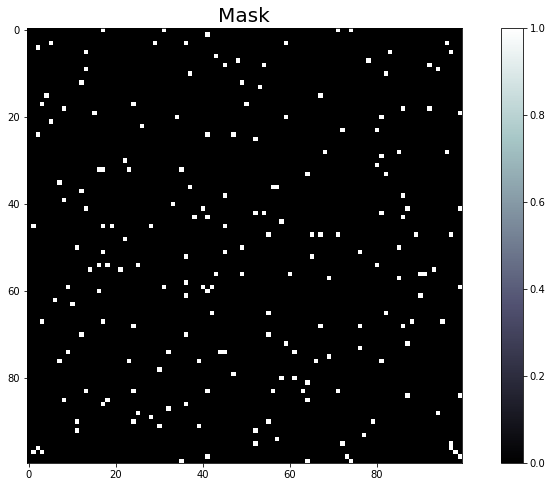

In [21]:
# Shape of the true image
image_shape = (100, 100)

# Load the mask
mask2d = np.load('cs_data/cs_mask.npy')

# Load the observation
y2d = np.load('cs_data/cs_obs_data.npy')

# Display the mask H
plot.display(mask2d, 'Mask', shape=image_shape, cmap='bone')

# Display the observation y
# plot.display(y2d, r'$y$', shape=(20, 10))

### <font color='blue'>Solutions</font>

<font color='red'>EXERCISE:</font> provide your solutions in the cell(s) below.


In [22]:
print('The percentage of samples used is:', mask2d[mask2d == 1].size / float(mask2d.size) * 100)

The percentage of samples used is: 2.0


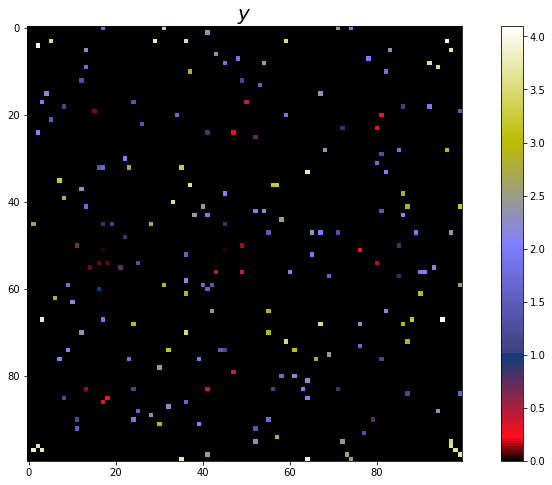

In [23]:
plot.display(upsample(y2d, mask2d), r'$y$', shape=image_shape)

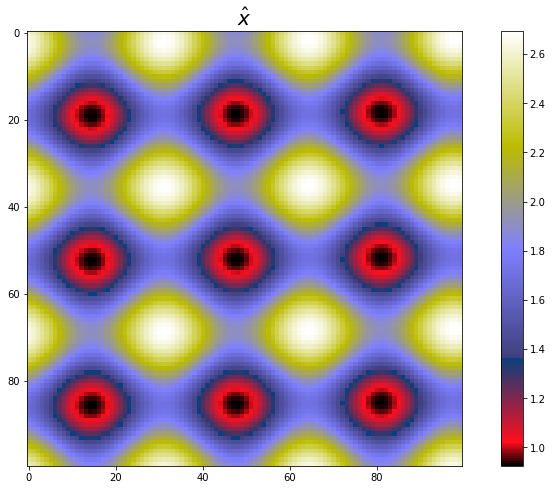

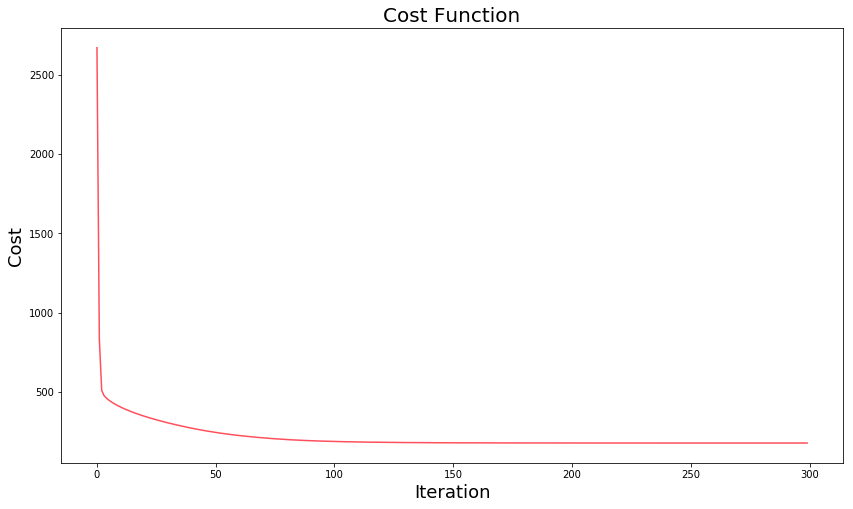

In [24]:
# Recover the sparse singal alpha
alpha_rec2d, cost2d = forwardBackward(y2d, first_guess=np.ones(mask2d.size), mask=mask2d, grad=grad, lambda_val=0.5, 
                                      n_iter=300, return_cost=True)
x_rec2d = fft(alpha_rec2d)

# Display the recovered signal x
plot.display(x_rec2d, title=r'$\hat{x}$', shape=image_shape)

# Display the cost function
plot.cost_plot(cost2d)

---

## Bonus Question